In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from time import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.set_option('display.max.columns', None)

In [2]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('Home_Loan/application_train.csv.tar.gz')

In [4]:
mm_scaler = MinMaxScaler()
std_scaler = StandardScaler()

def clean_data(df, test=True):
    global mm_scaler, std_scaler
    
    # Drop rows where target value is missing
    df.dropna(subset=["TARGET"], inplace=True)
    
    # Drop rows where important monetary values are missing
    df.dropna(subset=["AMT_INCOME_TOTAL", "AMT_CREDIT",
                      "AMT_ANNUITY", "AMT_GOODS_PRICE"],
              inplace=True)
    
    # Drop outliers
    if not test:
        idx = np.all(stats.zscore(df[["AMT_INCOME_TOTAL", "AMT_CREDIT",
                                      "AMT_ANNUITY", "AMT_GOODS_PRICE"]]) < 3, axis=1)
        df = df[idx]
    
    # Drop outlier from "DAYS_EMPLOYED" and the "SOCIAL_CIRCLE" columns
    df.drop(index=df[df["DAYS_EMPLOYED"] >= 50000].index, inplace=True)
    df.drop(index=df[df["OBS_30_CNT_SOCIAL_CIRCLE"] >= 100].index, inplace=True)
    df.drop(index=df[df["DEF_30_CNT_SOCIAL_CIRCLE"] >= 100].index, inplace=True)
    df.drop(index=df[df["OBS_60_CNT_SOCIAL_CIRCLE"] >= 100].index, inplace=True)
    df.drop(index=df[df["DEF_60_CNT_SOCIAL_CIRCLE"] >= 100].index, inplace=True)
    
    # Create list y with target values
    y = df["TARGET"].astype("int").astype("category")
    
    # Create DataFrame X for all features
    X = pd.DataFrame()
    
    # Copy already correct columns
    X["REGION_POPULATION_RELATIVE"] = df["REGION_POPULATION_RELATIVE"]
    
    # Convert data types
    X["FLAG_OWN_CAR"] = df["FLAG_OWN_CAR"].replace(["Y", "N"], [1, 0]).astype("int")
    X["FLAG_OWN_REALTY"] = df["FLAG_OWN_REALTY"].replace(["Y", "N"], [1, 0]).astype("int")
    X["REG_REGION_NOT_LIVE_REGION"] = df["REG_REGION_NOT_LIVE_REGION"].astype("int")
    X["REG_REGION_NOT_WORK_REGION"] = df["REG_REGION_NOT_WORK_REGION"].astype("int")
    X["LIVE_REGION_NOT_WORK_REGION"] = df["LIVE_REGION_NOT_WORK_REGION"].astype("int")
    X["REG_CITY_NOT_LIVE_CITY"] = df["REG_CITY_NOT_LIVE_CITY"].astype("int")
    X["REG_CITY_NOT_WORK_CITY"] = df["REG_CITY_NOT_WORK_CITY"].astype("int")
    X["FLAG_DOCUMENT_2"] = df["FLAG_DOCUMENT_2"].astype("int")
    X["FLAG_DOCUMENT_3"] = df["FLAG_DOCUMENT_3"].astype("int")
    X["FLAG_DOCUMENT_4"] = df["FLAG_DOCUMENT_4"].astype("int")
    X["FLAG_DOCUMENT_5"] = df["FLAG_DOCUMENT_5"].astype("int")
    X["FLAG_DOCUMENT_6"] = df["FLAG_DOCUMENT_6"].astype("int")
    X["FLAG_DOCUMENT_7"] = df["FLAG_DOCUMENT_7"].astype("int")
    X["FLAG_DOCUMENT_8"] = df["FLAG_DOCUMENT_8"].astype("int")
    X["FLAG_DOCUMENT_9"] = df["FLAG_DOCUMENT_9"].astype("int")
    X["FLAG_DOCUMENT_10"] = df["FLAG_DOCUMENT_10"].astype("int")
    X["FLAG_DOCUMENT_11"] = df["FLAG_DOCUMENT_11"].astype("int")
    X["FLAG_DOCUMENT_12"] = df["FLAG_DOCUMENT_12"].astype("int")
    X["FLAG_DOCUMENT_13"] = df["FLAG_DOCUMENT_13"].astype("int")
    X["FLAG_DOCUMENT_14"] = df["FLAG_DOCUMENT_14"].astype("int")
    X["FLAG_DOCUMENT_15"] = df["FLAG_DOCUMENT_15"].astype("int")
    X["FLAG_DOCUMENT_16"] = df["FLAG_DOCUMENT_16"].astype("int")
    X["FLAG_DOCUMENT_17"] = df["FLAG_DOCUMENT_17"].astype("int")
    X["FLAG_DOCUMENT_18"] = df["FLAG_DOCUMENT_18"].astype("int")
    X["FLAG_DOCUMENT_19"] = df["FLAG_DOCUMENT_19"].astype("int")
    X["FLAG_DOCUMENT_20"] = df["FLAG_DOCUMENT_20"].astype("int")
    X["FLAG_DOCUMENT_21"] = df["FLAG_DOCUMENT_21"].astype("int")
    
    # Create dummy variables for categorical columns
    X = pd.concat([X, pd.get_dummies(df[["NAME_CONTRACT_TYPE", "CODE_GENDER", "NAME_TYPE_SUITE",
                                         "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
                                         "NAME_HOUSING_TYPE", "ORGANIZATION_TYPE"]],
                                     drop_first=True)], 1)
    
    # Filling all NaNs with mean values
    col_names = df.loc[:, "EXT_SOURCE_1" : "NONLIVINGAREA_MEDI"].columns
    X[col_names] = df[col_names].fillna(value=df[col_names].median())
    X["TOTALAREA_MODE"] = df["TOTALAREA_MODE"].fillna(value=df["TOTALAREA_MODE"].median())
    
    social_circle = ["OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE"]
    X[social_circle] = df[social_circle].fillna(value=df[social_circle].median())
    
    enquiries = ["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK",
                 "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]
    X[enquiries] = df[enquiries].fillna(value=df[enquiries].median())    
    
    # Use Scaler
    if test:
        X[["CNT_CHILDREN"]] = mm_scaler.transform(df[["CNT_CHILDREN"]])
        X[["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "REGION_RATING_CLIENT_W_CITY"]] = std_scaler.transform(df[["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "REGION_RATING_CLIENT_W_CITY"]])
        X[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]] = mm_scaler.transform(df[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]] * -1)
        X[social_circle] = mm_scaler.transform(X[social_circle])
        X[enquiries] = mm_scaler.transform(X[enquiries])
    else:
        X[["CNT_CHILDREN"]] = mm_scaler.fit_transform(df[["CNT_CHILDREN"]])
        X[["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "REGION_RATING_CLIENT_W_CITY"]] = std_scaler.fit_transform(df[["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "REGION_RATING_CLIENT_W_CITY"]])
        X[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]] = mm_scaler.fit_transform(df[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]] * -1)
        X[social_circle] = mm_scaler.fit_transform(X[social_circle])
        X[enquiries] = mm_scaler.fit_transform(X[enquiries])
    
    return X, y

In [5]:
# preparing X and y for the split
X, y = clean_data(data, test=False)

In [6]:
# splitting the data with stratifying due imbalanced data
from sklearn.model_selection import train_test_split

RSEED = 50
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state = RSEED)

In [7]:
# importing Regression models and evaluation matrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import itertools

In [8]:
# Function for model training

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size] ,y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,
    #       then get predictions on the first 1000 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:1000])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 1000 training samples
    results['acc_train'] = accuracy_score(y_train[:1000],predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 1000 training samples
    results['f_beta_train'] = fbeta_score(y_train[:1000] ,predictions_train,beta=1.5)
        
    # Compute F_beta-score on the test set
    results['f_beta_test'] = fbeta_score(y_test,predictions_test,beta=1.5)
    
    # Compute Precision_score on the first 1000 training samples
    results['Precision_train'] = precision_score(y_train[:1000], predictions_train)
    
    # Compute Precision_score on the test set
    results['Precision_test'] = precision_score(y_test, predictions_test)
    
    # Compute Recall_score on the first 1000 training samples
    results['Recall_train'] = recall_score(y_train[:1000] ,predictions_train)
    
    # Compute Recall_score on the test set
    results['Recall_test'] = recall_score(y_test, predictions_test)
    
    # Compute roc_auc_score on the first 1000 training samples
    results['Roc_Auc_Score_train'] = roc_auc_score(y_train[:1000] ,predictions_train)
    
    # Compute roc_auc_score on the first 1000 training samples
    results['Roc_Auc_Score_test'] = roc_auc_score(y_test, predictions_test)
    
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, len(X_train)))
    print("*" *100)
    print()
    
    # confusion matrix
    cm = confusion_matrix(y_test, predictions_test)
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
    
    # plotting the confusion matrix
    disp = plot_confusion_matrix(learner, X_test, y_test,
                             display_labels=['non-defaulter', 'defaulter'],
                             cmap=plt.cm.Blues, 
                             normalize=None,
                             values_format = 'd')

    plt.grid(False)
    plt.show()
    print()
    print()
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, predictions_test)
    
    # plotting the ROC_curve:
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();
    print("-" *100)
    print()
    
    # Return the results
    return results

LogisticRegression trained on 172083 samples.
****************************************************************************************************



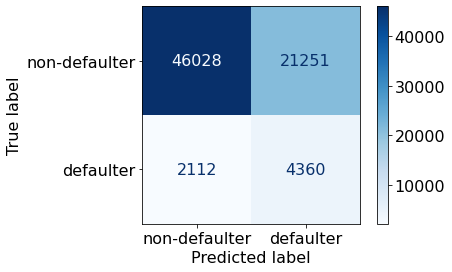

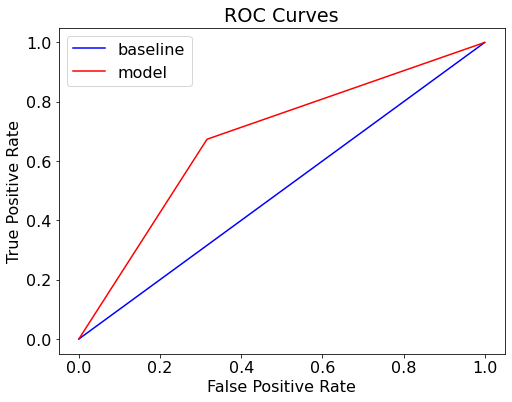

----------------------------------------------------------------------------------------------------

DecisionTreeClassifier trained on 172083 samples.
****************************************************************************************************



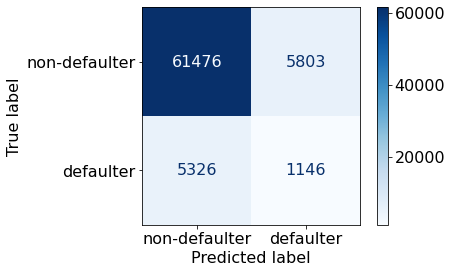

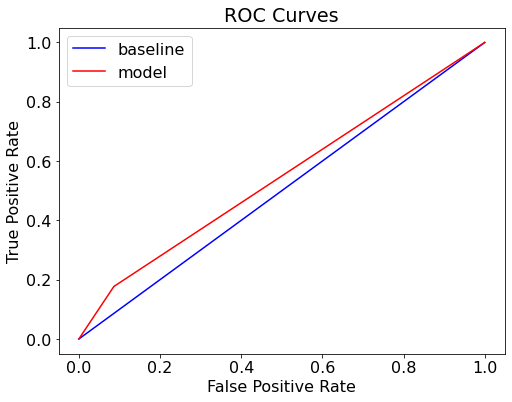

----------------------------------------------------------------------------------------------------



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finis

RandomForestClassifier trained on 172083 samples.
****************************************************************************************************



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    3.5s finished


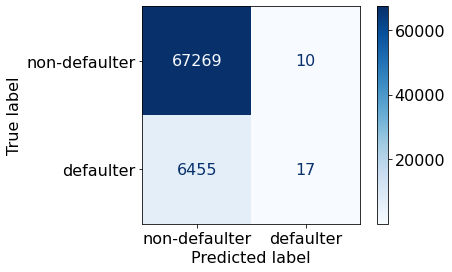

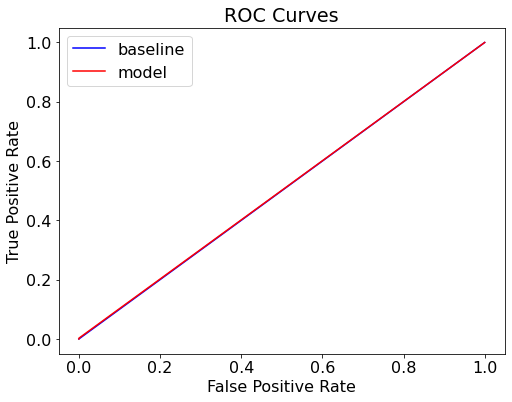

----------------------------------------------------------------------------------------------------



In [20]:
# Initialize the three models, the random states are set to 50 so we know how to reproduce the model later
clf_A = LogisticRegression(class_weight='balanced',random_state=RSEED)
clf_B = DecisionTreeClassifier(random_state=RSEED, class_weight='balanced')
clf_C = RandomForestClassifier(n_estimators=500, 
                               random_state=RSEED, 
                               max_features = 'sqrt', class_weight='balanced',  
                               n_jobs=-1, verbose = 1)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    train_predict(clf, len(X_train), X_train, y_train, X_test, y_test)

In [28]:
#Printing out the values
for i in results.items():
    print (i)

    #display(pd.DataFrame(i[1]).rename(columns={1:'100%'}))

('LogisticRegression', {})
('DecisionTreeClassifier', {})
('RandomForestClassifier', {})


In [27]:
print(results)

{'LogisticRegression': {}, 'DecisionTreeClassifier': {}, 'RandomForestClassifier': {}}


## Using Random Search CV to find the best parameter

In [11]:
from sklearn.model_selection import RandomizedSearchCV

# Random forest model with Random Search CV

# Hyperparameter tuning
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 5, 
                        n_iter = 10, verbose = 5, random_state=RSEED)

# Fit 
rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed: 24.8min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 26.1min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=50),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                     

In [12]:
rs.best_params_

{'n_estimators': 87,
 'min_samples_split': 10,
 'max_leaf_nodes': 28,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

## Use Best Model

Now we can take the best model (it has already been trained) and evaluate it. Hopefully it does better than the stock Random Forest.

In [13]:
best_model = rs.best_estimator_

In [14]:
train_rf_predictions = best_model.predict(X_train)
train_rf_probs = best_model.predict_proba(X_train)[:, 1]

test_rf_predictions = best_model.predict(X_test)
test_rf_probs = best_model.predict_proba(X_test)[:, 1]

In [15]:
print(confusion_matrix(y_test, test_rf_predictions))

[[67279     0]
 [ 6472     0]]


In [16]:
# ensemble model no 2 XGboost
from xgboost import XGBClassifier

In [17]:
model4 = XGBClassifier()
model4.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finis

RandomForestClassifier trained on 172083 samples.
****************************************************************************************************



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    2.6s finished


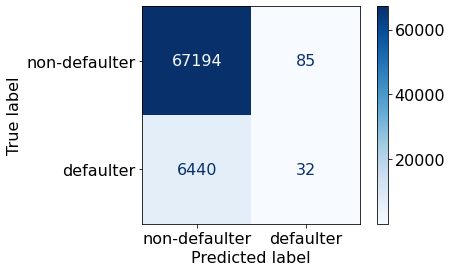

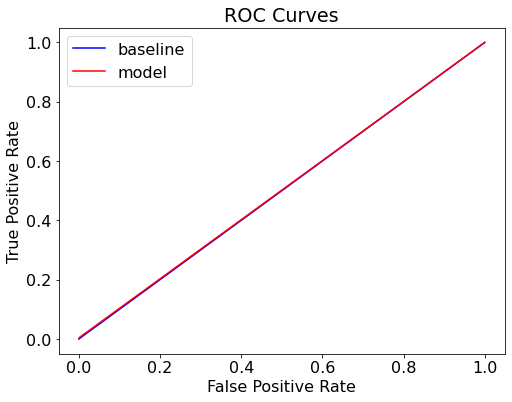

----------------------------------------------------------------------------------------------------



{'train_time': 29.33877420425415,
 'pred_time': 2.7368199825286865,
 'acc_train': 1.0,
 'acc_test': 0.9115266233678188,
 'f_beta_train': 1.0,
 'f_beta_test': 0.007084951290959875,
 'Precision_train': 1.0,
 'Precision_test': 0.27350427350427353,
 'Recall_train': 1.0,
 'Recall_test': 0.004944375772558714,
 'Roc_Auc_Score_train': 1.0,
 'Roc_Auc_Score_test': 0.5018404900310793}

In [22]:
features = ['REGION_POPULATION_RELATIVE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
            'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 
            'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 
            'REG_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 
            'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 
            'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9', 
            'FLAG_DOCUMENT_10', 'EXT_SOURCE_2', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH']
train_predict(clf, len(X_train), X_train[features], y_train, 
              X_test[features], y_test)